## Step #1: Explore and prep data

In [1]:
import pandas as pd
df = pd.read_csv('Dataset/bank-additional-full.csv', delimiter=';')

In [2]:
# list and drop columns that are less related to the target based on my judgment
cols_to_drop = ['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
df = df.drop(columns=cols_to_drop).rename(columns={'job': 'job_type', 'default': 'default_status', 
                                                   'housing': 'housing_loan_status', 'loan': 'personal_loan_status', 
                                                   'contact': 'contact_type', 'month': 'contact_month', 
                                                   'day_of_week': 'contact_day_of_week', 'campaign': 'num_contacts', 
                                                   'pdays': 'days_last_contact', 'previous': 'previous_contacts', 
                                                   'poutcome': 'previous_outcome', 
                                                   'y': 'result'
                                                    })
# convert the target to numerical values
df['result'] = df['result'].replace({'yes': 1, 'no': 0})

In [3]:
df.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

In [5]:
df['result'].value_counts()

0    36548
1     4640
Name: result, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='result')
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

## Step #2: Build a pipeline of training

In [11]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=8, ...))])

## Step #3: Set up hyperparameter tuning

In [15]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

## Step #4: Train the XGBoost model

In [16]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None, gpu_id=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

## Step #5: Evaluate the model and make predictions

In [17]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['job_type', 'marital', 'education',
                                     'default_status', 'housing_loan_status',
                                     'personal_loan_status', 'contact_type',
                                     'contact_month', 'contact_day_of_week',
                                     'previous_outcome'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.7750018497221565,
                               colsample_bynode=0.561443744159...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.4299244814327041, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=8, ...))])

In [18]:
opt.best_score_

0.7682615184517072

In [19]:
opt.score(X_test, y_test)

0.7775377818529177

In [20]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
opt.predict_proba(X_test)

array([[0.9388285 , 0.06117146],
       [0.95764756, 0.04235244],
       [0.9209218 , 0.07907818],
       ...,
       [0.5243679 , 0.47563204],
       [0.95974046, 0.04025955],
       [0.8426395 , 0.1573605 ]], dtype=float32)

## Step #6: Measure feature importance

In [22]:
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['job_type', 'marital', 'education', 'default_status',
                      'housing_loan_status', 'personal_loan_status',
                      'contact_type', 'contact_month', 'contact_day_of_week',
                      'previous_outcome'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.7750018497221565,
                colsample_bynode=0.5614437441596264,
                colsample_bytree=0.9126202065825759, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=8.289497472648083, gpu_id=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.4299244814327041, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=None, missi

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

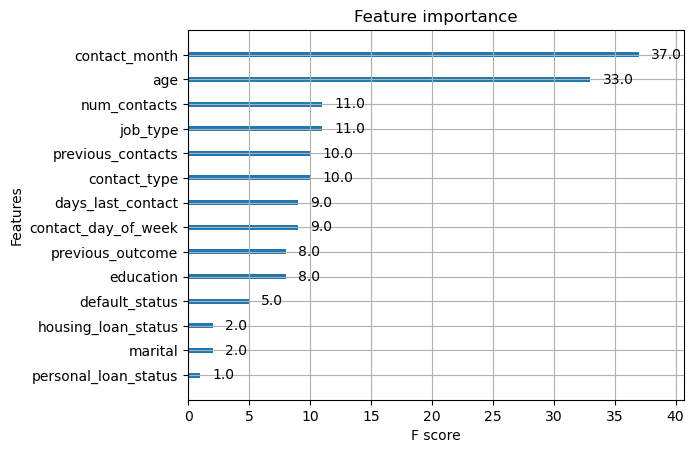

In [23]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)